In [1]:
from models import MultiModalRegressionTransformer

model = MultiModalRegressionTransformer(384, 26, 64, 28, 6, 16, 4, 0)






In [2]:
import torch
import torch.nn as nn
model_path = 'val_loss0.1225_DPR_0.1_MP_0.3_DM_64_TL_4_heads_16.pth'

model.load_state_dict(torch.load(model_path, map_location='cpu'))
model.eval()


MultiModalRegressionTransformer(
  (embeddings_module): MultiModalInputEmbeddings(
    (smiles_proj): FeedForwardNeuralNetwork(
      (fc1): Linear(in_features=384, out_features=1536, bias=True)
      (relu): ReLU()
      (fc2): Linear(in_features=1536, out_features=64, bias=True)
    )
    (property_embedding): Embedding(26, 64)
    (value_proj): Linear(in_features=1, out_features=64, bias=True)
    (token_type_embeddings): Embedding(6, 64)
    (position_encodings): PositionalEncoding(
      (dropout): Dropout(p=0, inplace=False)
    )
    (LayerNorm): LayerNorm((64,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0, inplace=False)
  )
  (transformer_decoder_layers): ModuleList(
    (0-3): 4 x MaskedMultiHeadSelfAttentionBlock(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
      )
      (linear1): Linear(in_features=64, out_features=256, bias=True)
      (dropout_ffn): Dropout(p=0, 

In [3]:
for name, module in model.named_modules():
    if isinstance(module, nn.Embedding):
        print(f"Found Embedding Layer: {name}")
        

Found Embedding Layer: embeddings_module.property_embedding
Found Embedding Layer: embeddings_module.token_type_embeddings


In [4]:

embedding_layer = model.embeddings_module.property_embedding

# Get the weights (embeddings)
# .weight returns a torch.nn.Parameter, so we typically convert it to a tensor
embeddings = embedding_layer.weight.data
transposed_data = embeddings.T  # Transpose the embeddings tensor 



print(f"Shape of embeddings: {embeddings.shape}")
print(f"First 5 embedding vectors:\n {embeddings[:5]}")

Shape of embeddings: torch.Size([26, 64])
First 5 embedding vectors:
 tensor([[ 1.7397e-01,  4.4000e-01, -4.2025e-02,  1.0678e-01, -3.5538e-01,
         -1.0308e-01, -1.2504e-01, -6.2801e-01, -7.9352e-01, -7.1092e-02,
          4.5158e-02,  7.6325e-01,  6.8636e-01,  2.5335e-01, -5.0183e-01,
         -3.6886e-01,  4.4896e-01,  1.5742e-01,  3.8146e-01, -1.0866e-01,
          1.9397e-01, -2.7917e-01,  1.4337e-02, -8.7395e-01,  2.3850e-01,
         -3.1811e-02, -8.4418e-02, -7.5415e-01,  4.2758e-02,  3.1894e-01,
         -5.8553e-01, -4.1614e-01,  2.4902e-01, -7.7619e-01,  5.8051e-01,
         -2.2224e-01, -2.3386e-01, -5.7854e-01,  9.1119e-03, -1.7602e-02,
         -2.5532e-01, -3.9916e-01, -7.0654e-01, -2.3933e-01,  1.0779e-01,
         -2.4809e-01, -1.0879e-01, -1.1734e-01,  2.9003e-01, -3.9132e-01,
          4.4373e-01, -2.0202e-01,  5.5250e-01,  5.8102e-02,  2.8990e-01,
         -5.3882e-01,  9.4052e-02, -6.2159e-01,  2.7250e-01, -4.4295e-01,
          3.5103e-01, -6.5126e-01,  3.4468

In [5]:
import pandas as pd
WORD_TOKENS = ['alkane', 'aromatic', 'halohydrocarbon', 'ether', 'ketone', 'ester', 'nitrile', 'amine', 'amide', 'misc_N_compound', 'carboxylic_acid', 'monohydric_alcohol' , 'polyhydric_alcohol', 'other','ET30', 'alpha', 'beta', 'pi_star', 'SA', 'SB', 'SP', 'SdP', 'N_mol_cm3', 'n', 'fn', 'delta']


# Convert to NumPy array
transposed = embeddings.T
numpy_array = embeddings.numpy()

# Create DataFrame
# The columns will be indexed 0, 1, 2...
df = pd.DataFrame(transposed)
print(df.shape)

df.columns = WORD_TOKENS


(64, 26)


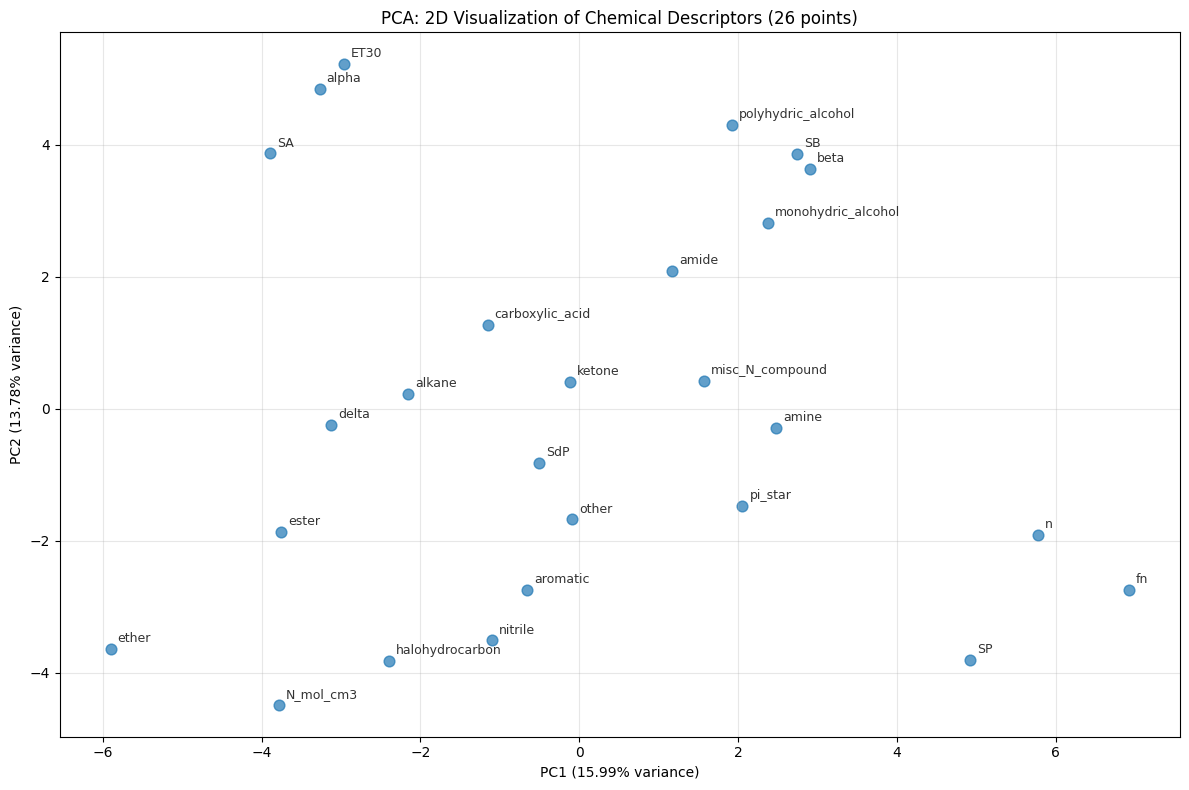

Explained variance ratio: [0.15994951 0.1377604 ]
Total variance explained: 29.77%


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def pca_scatter_plot(df, n_components=2):
    """
    Reduce each column (384 dimensions) to n_components using PCA and create scatter plot.
    
    Args:
        df: DataFrame with shape (384, 26) - each column will be reduced to 2D
        n_components: Number of PCA components (default=2)
    """
    # Transpose so each row represents a column (26 rows, 384 features each)
    df_transposed = df.T
    
    # Standardize the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df_transposed)
    
    # Apply PCA to reduce from 384 dimensions to 2
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(scaled_data)
    
    # Create scatter plot
    plt.figure(figsize=(12, 8))
    plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.7, s=60)
    
    # Add labels for each point (using column names)
    for i, col_name in enumerate(df.columns):
        plt.annotate(col_name, (pca_result[i, 0], pca_result[i, 1]), 
                    xytext=(5, 5), textcoords='offset points', 
                    fontsize=9, alpha=0.8)
    
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    plt.title('PCA: 2D Visualization of Chemical Descriptors (26 points)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
    print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.2%}")
    
    return pca_result, pca
    

# Apply to your DataFrame
pca_result, pca_model = pca_scatter_plot(df)

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity, manhattan_distances
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform

def analyze_descriptor_distances(df):
    """
    Analyze distances/similarities between chemical descriptors using various metrics.
    
    Args:
        df: DataFrame with shape (384, 26)
    """
    # Transpose so each row is a descriptor
    df_transposed = df.T
    
    # Standardize the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df_transposed)
    
    # 1. Euclidean Distance Matrix
    euclidean_dist = euclidean_distances(scaled_data)
    euclidean_df = pd.DataFrame(euclidean_dist, 
                               index=df.columns, 
                               columns=df.columns)
    
    # 2. Cosine Similarity (then convert to distance)
    cosine_sim = cosine_similarity(scaled_data)
    cosine_dist = 1 - cosine_sim  # Convert similarity to distance
    cosine_df = pd.DataFrame(cosine_dist,
                            index=df.columns,
                            columns=df.columns)
    
    # 3. Manhattan Distance
    manhattan_dist = manhattan_distances(scaled_data)
    manhattan_df = pd.DataFrame(manhattan_dist,
                               index=df.columns,
                               columns=df.columns)
    
    # 4. Correlation Distance
    corr_matrix = df.corr()
    corr_dist = 1 - abs(corr_matrix)  # Distance = 1 - |correlation|
    
    # Plotting
    fig, axes = plt.subplots(2, 2, figsize=(16, 14))
    
    # Euclidean Distance Heatmap
    sns.heatmap(euclidean_df, annot=False, cmap='viridis', ax=axes[0,0])
    axes[0,0].set_title('Euclidean Distance Matrix')
    axes[0,0].tick_params(axis='x', rotation=45)
    axes[0,0].tick_params(axis='y', rotation=0)
    
    # Cosine Distance Heatmap
    sns.heatmap(cosine_df, annot=False, cmap='plasma', ax=axes[0,1])
    axes[0,1].set_title('Cosine Distance Matrix')
    axes[0,1].tick_params(axis='x', rotation=45)
    axes[0,1].tick_params(axis='y', rotation=0)
    
    # Manhattan Distance Heatmap
    sns.heatmap(manhattan_df, annot=False, cmap='inferno', ax=axes[1,0])
    axes[1,0].set_title('Manhattan Distance Matrix')
    axes[1,0].tick_params(axis='x', rotation=45)
    axes[1,0].tick_params(axis='y', rotation=0)
    
    # Correlation Distance Heatmap
    sns.heatmap(corr_dist, annot=False, cmap='coolwarm', ax=axes[1,1])
    axes[1,1].set_title('Correlation Distance Matrix')
    axes[1,1].tick_params(axis='x', rotation=45)
    axes[1,1].tick_params(axis='y', rotation=0)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'euclidean': euclidean_df,
        'cosine': cosine_df, 
        'manhattan': manhattan_df,
        'correlation': corr_dist
    }

def hierarchical_clustering(df, method='euclidean'):
    """
    Perform hierarchical clustering and show dendrogram.
    
    Args:
        df: DataFrame with shape (384, 26)
        method: Distance metric ('euclidean', 'cosine', 'correlation', etc.)
    """
    df_transposed = df.T
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df_transposed)
    
    # Compute distance matrix
    if method == 'cosine':
        # For cosine, use 1 - cosine_similarity
        cos_sim = cosine_similarity(scaled_data)
        distances = 1 - cos_sim
        condensed_dist = squareform(distances, checks=False)
    else:
        condensed_dist = pdist(scaled_data, metric=method)
    
    # Perform hierarchical clustering
    linkage_matrix = linkage(condensed_dist, method='ward')
    
    # Create dendrogram
    plt.figure(figsize=(12, 8))
    dendrogram(linkage_matrix, labels=df.columns, orientation='top')
    plt.title(f'Hierarchical Clustering Dendrogram ({method} distance)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return linkage_matrix

def find_closest_pairs(distance_df, n_pairs=5):
    """Find the n closest pairs of descriptors."""
    # Set diagonal to infinity to ignore self-comparisons
    dist_copy = distance_df.copy()
    np.fill_diagonal(dist_copy.values, np.inf)
    
    # Find closest pairs
    closest_pairs = []
    for i in range(len(dist_copy)):
        for j in range(i+1, len(dist_copy)):
            distance = dist_copy.iloc[i, j]
            closest_pairs.append((distance, dist_copy.index[i], dist_copy.columns[j]))
    
    # Sort by distance and return top n
    closest_pairs.sort(key=lambda x: x[0])
    
    print(f"Top {n_pairs} closest descriptor pairs:")
    for i, (dist, desc1, desc2) in enumerate(closest_pairs[:n_pairs]):
        print(f"{i+1}. {desc1} ↔ {desc2}: {dist:.3f}")
    
    return closest_pairs[:n_pairs]

# Example usage:
# distances = analyze_descriptor_distances(df)
# clustering = hierarchical_clustering(df, method='euclidean')
# closest = find_closest_pairs(distances['euclidean'])

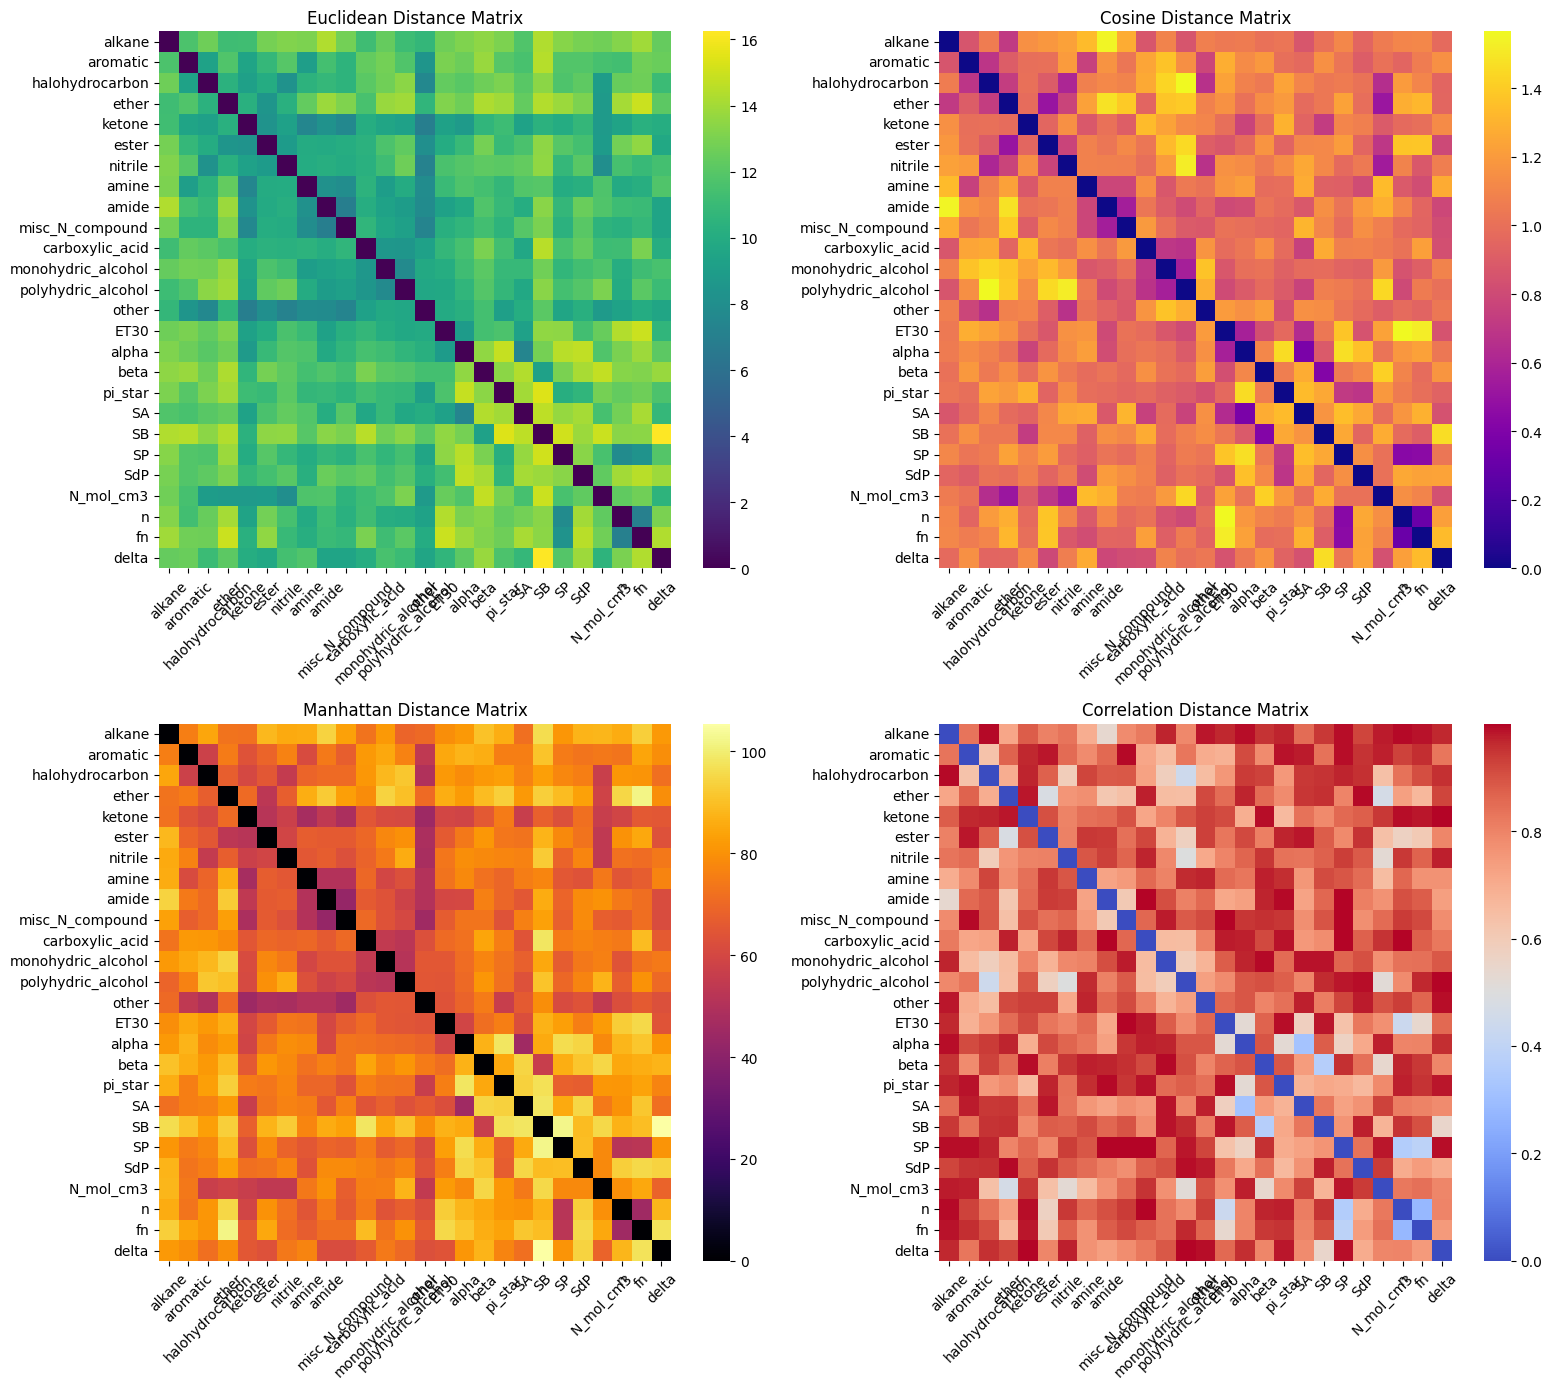

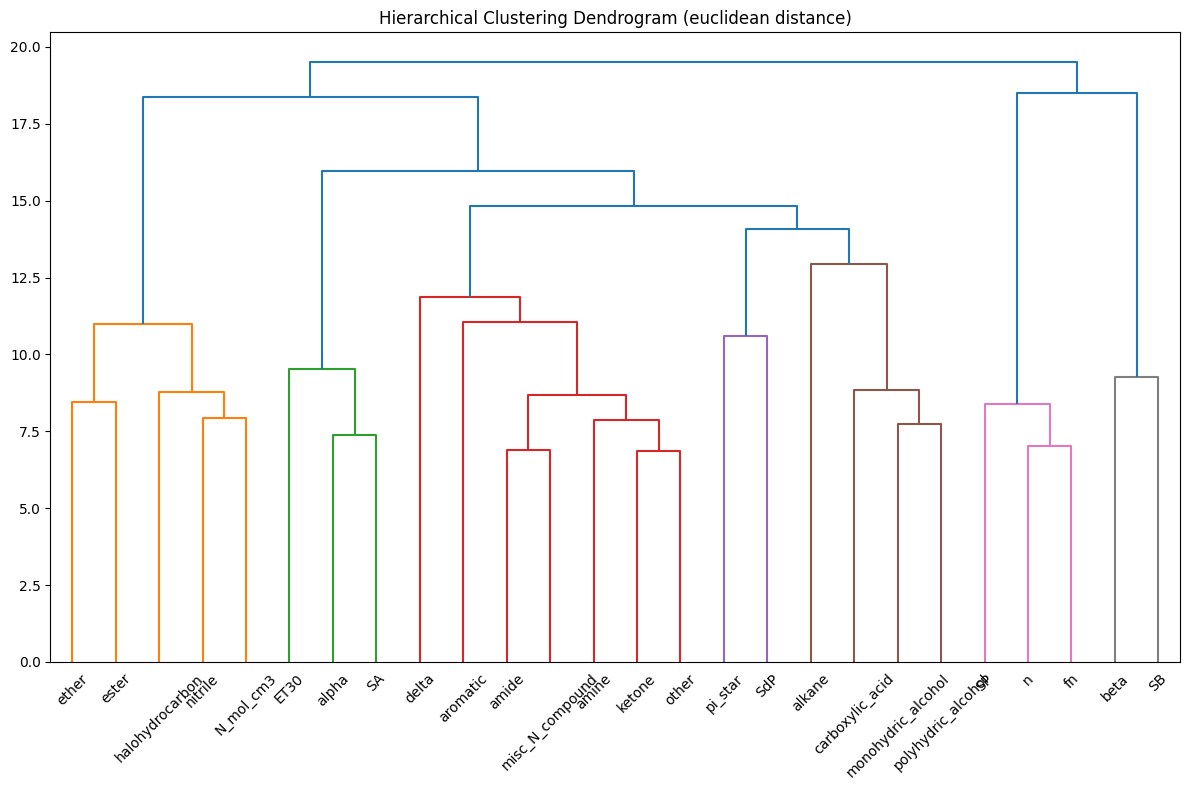

Top 5 closest descriptor pairs:
1. ketone ↔ other: 6.874
2. amide ↔ misc_N_compound: 6.886
3. n ↔ fn: 7.007
4. nitrile ↔ other: 7.129
5. misc_N_compound ↔ other: 7.323


In [8]:
distances = analyze_descriptor_distances(df)
clustering = hierarchical_clustering(df, method='euclidean')
closest = find_closest_pairs(distances['euclidean'])

In [ ]:
#numpy_array = transposed_data.numpy()
# Create DataFrame with appropriate column names
df_vocab = pd.DataFrame(transposed_data)
print(df_vocab.shape)
df_vocab.columns = WORD_TOKENS
print(df_vocab.columns)  # Display the column names
  # Select the last 12 columns for PCA

(2, 12)


ValueError: Length mismatch: Expected axis has 12 elements, new values have 26 elements

In [18]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [20]:
data_for_pca = df.tail(12)
print(f"Shape of data for PCA: {data_for_pca.shape}")

# Convert the selected data to a NumPy array for PCA
X = data_for_pca.values

Shape of data for PCA: (12, 384)


In [21]:
pca = PCA(n_components=2)

# Fit PCA to the data and transform it
# The fit_transform method fits PCA to X and then applies the dimensionality reduction
X_reduced = pca.fit_transform(X)

print(f"Shape of PCA reduced data: {X_reduced.shape}")
print(f"Explained variance ratio of principal components: {pca.explained_variance_ratio_}")
print(f"Total explained variance: {pca.explained_variance_ratio_.sum():.2f}")

Shape of PCA reduced data: (12, 2)
Explained variance ratio of principal components: [0.14462486 0.11333592]
Total explained variance: 0.26


float32


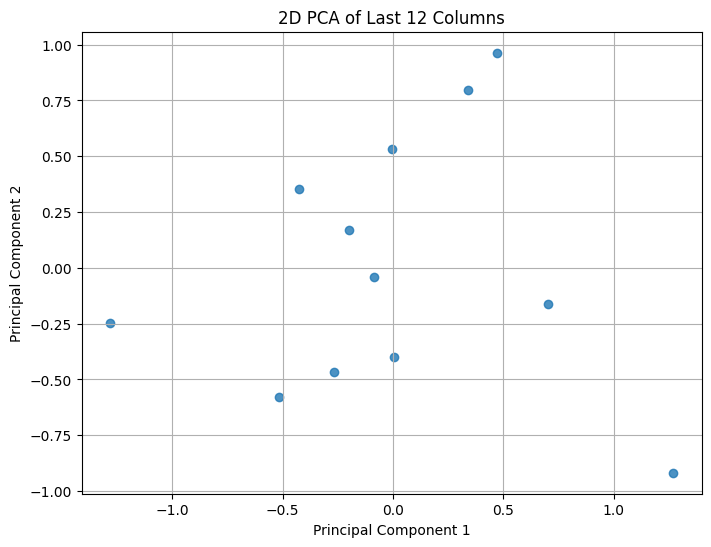

In [22]:
# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], alpha=0.8)

# Add labels and title
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D PCA of Last 12 Columns')
plt.grid(True)
plt.show()

In [25]:
transposed_data = X_reduced.T
print(f"Shape after transposing: {transposed_data.shape}") # (2, 12)

# Create a DataFrame from the transposed data
# Now, the 12 columns will correspond to the original 12 data points (rows)
# and the 2 rows will correspond to the 2 principal components.
df_12_cols = pd.DataFrame(transposed_data)
print(df_12_cols.shape)

Shape after transposing: (2, 12)
(2, 12)


In [ ]:
WORD_TOKENS[-12:]

df_12_cols.columns = WORD_TOKENS[-12:] 
print(df_12_cols.columns) # Assign the last 12 tokens as column names

Index(['ET30', 'alpha', 'beta', 'pi_star', 'SA', 'SB', 'SP', 'SdP',
       'N_mol_cm3', 'n', 'fn', 'delta'],
      dtype='object')


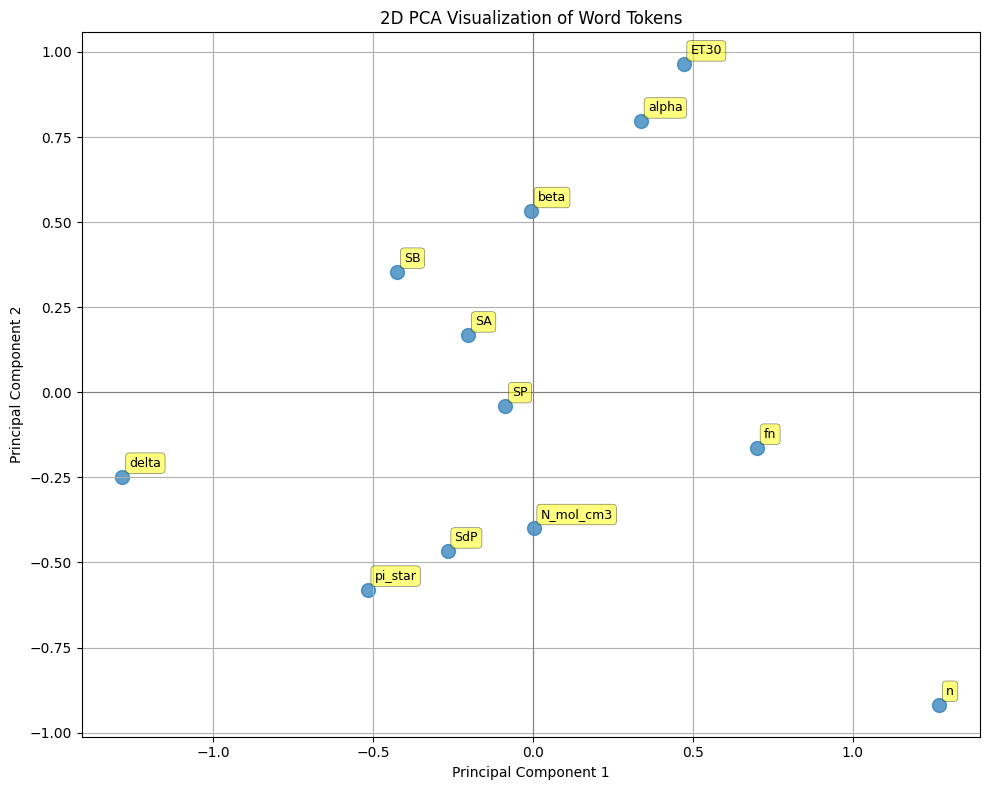

In [29]:
x_coords = df_12_cols.iloc[0].values

# The second row of df_12_cols contains the values for Principal Component 2
y_coords = df_12_cols.iloc[1].values

# The labels for each point are the column names
labels = df_12_cols.columns.tolist()

# --- Create the labeled scatter plot ---
plt.figure(figsize=(10, 8)) # Adjust figure size for better readability of labels

# Create the scatter plot
plt.scatter(x_coords, y_coords, s=100, alpha=0.7) # s is marker size

# Add labels to each point
for i, label in enumerate(labels):
    plt.annotate(
        label, # The text label
        (x_coords[i], y_coords[i]), # The (x, y) coordinates of the point
        textcoords="offset points", # How to position the text
        xytext=(5,5), # Offset from the point (x, y)
        ha='left', # Horizontal alignment
        va='bottom', # Vertical alignment
        fontsize=9, # Font size of the label
        bbox=dict(boxstyle="round,pad=0.3", fc="yellow", alpha=0.5, ec="k", lw=0.5) # Optional: add a background box
    )

# Add plot titles and labels
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D PCA Visualization of Word Tokens')
plt.grid(True)
plt.axhline(0, color='grey', linewidth=0.8) # Add horizontal line at y=0
plt.axvline(0, color='grey', linewidth=0.8) # Add vertical line at x=0

# Adjust plot limits if labels are cut off
plt.tight_layout() # Adjust layout to prevent labels from overlapping with plot edges

plt.show()